In [1]:
#Figure out where the RT stops are located in terms of gene types and gene features for protein coding genes
#Remember to do this separately for DMSO vs. TAM

#I will generate a set of transcript regions from Ensembl 75 gtf

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%%time
#get the gene expression file ready

#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0_fpkm','twist_d14_fpkm'])

#add a row with twist_d0_d14_fpkm_sum
twist_gene_exp_df['twist_d0_d14_fpkm_sum'] = twist_gene_exp_df.apply(lambda row: row['twist_d0_fpkm']+row['twist_d14_fpkm'],axis=1)

#we want to calculate TPM
#Equation from Harold Pimentel's blog: exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
#Do I need to add a pseudocount here?

pseudocount = 1

twist_d0_fpkm_sum = twist_gene_exp_df.twist_d0_fpkm.sum()
twist_d14_fpkm_sum = twist_gene_exp_df.twist_d14_fpkm.sum()
twist_gene_exp_df['twist_d0_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d0_fpkm']+pseudocount)-np.log(twist_d0_fpkm_sum) + np.log(1e6)),axis=1)
twist_gene_exp_df['twist_d14_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d14_fpkm']+pseudocount)-np.log(twist_d14_fpkm_sum) + np.log(1e6)),axis=1)


#add in the length of the gene as calulated by cufflinks

twist_gene_exp_df['chr'] = twist_gene_exp_df['gene_coords'].str.split(':').str[0]
twist_gene_exp_df['coords'] = twist_gene_exp_df['gene_coords'].str.split(':').str[1]
twist_gene_exp_df['gene_length'] = twist_gene_exp_df['coords'].str.split('-').str[1].astype(int) - twist_gene_exp_df['coords'].str.split('-').str[0].astype(int)


#Try plotting the fpkm distribution in each of these - I did this in cummerbund in R

#also bring in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
twist_gene_exp_df = pd.merge(twist_gene_exp_df,gene_name_and_biotype_df,on='ens_gene',how='left')

#collect a dictionary with ens_gene and length for use later. Name gene_and_length_dict
gene_and_length = twist_gene_exp_df[['ens_gene','gene_length']]
gene_and_length.to_csv('ens_gene_and_length',sep='\t',index=False,header=False)
gene_and_length_dict = {}
with open('ens_gene_and_length') as f:
    for line in f:
        line = line.strip().split('\t')
        gene_and_length_dict[line[0]] = line[1]
        
#collect a dictionary with ens_gene and summed expression in both cells
gene_and_fpkm_sum = twist_gene_exp_df[['ens_gene','twist_d0_d14_fpkm_sum']]
gene_and_fpkm_sum.to_csv('ens_gene_and_fpkm_sum',sep='\t',index=False,header=False)
gene_and_fpkm_sum_dict = {}
with open('ens_gene_and_fpkm_sum') as f:
    for line in f:
        line = line.strip().split('\t')
        gene_and_fpkm_sum_dict[line[0]] = float(line[1])


CPU times: user 3.79 s, sys: 68 ms, total: 3.86 s
Wall time: 3.9 s


In [3]:
#DMSO DMSO DMSO DMSO

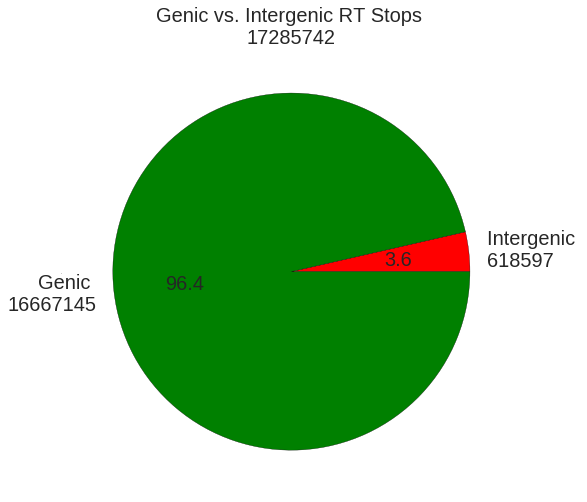

In [10]:
#I want to use the miRNA and snoRNA filtered RT stops to prevent assignment of those RT stops to genes
#I don't want to use clipper filtered though

#Get a gene expression file ready - use the clipper hg19_v19 files
#NOTE - you will lose a few clusters, but very small when overlapping with hg19_v19 file
header = ['chrom','start','end','ens_gene','blank','strand']
hg19_v19 = pd.read_csv('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_genes_cleaned.bed',sep='\t',names=header)
hg19_v19['ens_gene'] = hg19_v19.ens_gene.str.split('.').str[0]

#load the biotypes file I downloaded from ensembl biomart - not sure how complete this is
header = ['ens_gene','external_gene_name','biotype']
biotypes = 'GO_analysis/ensembl_gene_id_external_gene_names_biotype'
biotypes_df = pd.read_csv(biotypes,sep='\t',names=header)

#merge these two - not there are about 5000 that do not overlap. We thus don't know the biotype and the gene name
genes_merge_df = pd.merge(hg19_v19,biotypes_df,on='ens_gene',how='left')

#make this into a pbt
genes_merge_bt = pbt.BedTool.from_dataframe(genes_merge_df,na_rep='NaN')

#Import the clipper raw data merged in the RT_stops.bed file. Do this in pbt
rt_bt = pbt.BedTool('hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed')

#Intersect with the gene file - remember,there will be some duplicates
rt_bt_intersect = rt_bt.intersect(b=genes_merge_bt,wo=True,s=True)
rt_bt_intersect.saveas('hnM_DMSO_clipper/hnM_DMSO_RT_stops_genes')
rt_bt_non_intersect = rt_bt.intersect(b=genes_merge_bt,wa=True,s=True,v=True)

#merge the intersect file, keep RT stops together
rt_bt_intersect_merge = rt_bt_intersect.merge(d=-1,s=True,c=[4,5,10,13,14],o=['mean','mean','distinct','distinct','distinct'])
rt_bt_intersect_merge.saveas('hnM_DMSO_clipper/hnM_DMSO_RT_stops_genes_merged')

#Convert to dataframe
intersect_header = ['chrom','start','end','strand','blank','RT_stops','ens_gene','external_gene_name','biotype']
non_intersect_header = ['chrom','start','end','blank','RT_stops','strand']

rt_bt_intersect_merge_dataframe = rt_bt_intersect_merge.to_dataframe(names = intersect_header)
rt_bt_non_intersect_dataframe = rt_bt_non_intersect.to_dataframe(names = non_intersect_header)

#add "intergenic" biotype to non_genic
rt_bt_non_intersect_dataframe['biotype'] = 'intergenic'

#Indicate in another column genic = Yes or No
rt_bt_intersect_merge_dataframe['genic'] = 'Yes'
rt_bt_non_intersect_dataframe['genic'] = 'No'

#concatenate the genic and non_genic dataframes and save this
rt_bt_combined_df = pd.concat([rt_bt_intersect_merge_dataframe,rt_bt_non_intersect_dataframe],ignore_index=True)

#save the combined DF - remember this is for non clipper sig
rt_bt_combined_df.to_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_gene_and_biotype_annotated',sep='\t',header=True,index=False,na_rep='NaN')

#make a pie chart for genic vs. intergenic total number of RT stops and unique binding sites
genic_group = rt_bt_combined_df.groupby(by='genic')
genic_sums = genic_group.RT_stops.sum()
total = genic_sums.Yes + genic_sums.No
total = total.astype('str')
intergenic = genic_sums.No.astype('str')
genic = genic_sums.Yes.astype('str')
genic_pie = genic_sums.plot.pie(figsize=(8,8),labels=['Intergenic \n'+intergenic,'Genic \n'+ genic],colors=['r','g'],autopct='%.1f',fontsize=20,title='Genic vs. Intergenic RT Stops')
genic_pie.set_title('Genic vs. Intergenic RT Stops \n'+total,fontsize=20)
genic_pie.set_ylabel('no',fontsize=1)

In [39]:
#apply the id to figure things out

def make_an_rt_stop_id(dataframe):
    dataframe['id'] = dataframe.apply(lambda row: row['chrom'] + ':' + str(row['start']) + ':' + str(row['end']) + ':' + row['strand'], axis=1)
    return dataframe

# rt_bt_intersect_merge_dataframe = make_an_rt_stop_id(rt_bt_intersect_merge_dataframe)
# rt_bt_non_intersect_dataframe = make_an_rt_stop_id(rt_bt_non_intersect_dataframe)
rt_bt_combined_df = make_an_rt_stop_id(rt_bt_combined_df)

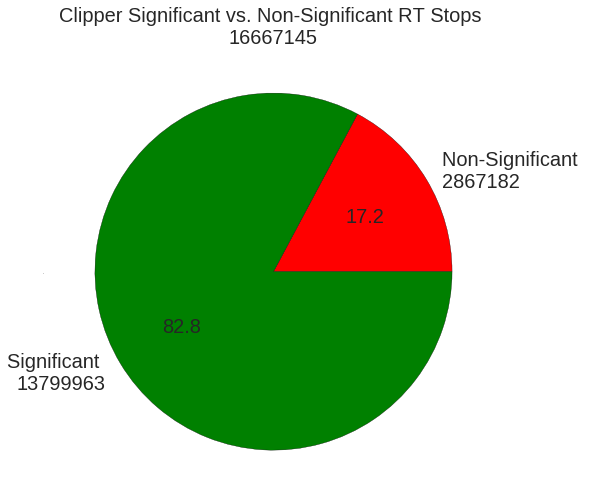

In [47]:
#Make a pie chart for total number of clipper significant vs non significant
#Make this a subset of the one above - is there a way to only include the genic RT stops

columns = ['chrom','start','end','score','RT_stops','strand']
sig_df = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig',sep='\t',names=columns)
non_sig_df = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_non_sig',sep='\t',names=columns)

#add a clipper_sig column with Yes or No
sig_df['clipper_sig'] = 'Yes'
non_sig_df['clipper_sig'] = 'No'

#Concat the dataframes
RT_through_clipper_df = pd.concat([sig_df,non_sig_df],ignore_index=True)

#add ID
RT_through_clipper_df = make_an_rt_stop_id(RT_through_clipper_df)

#now merge with the rt_bt_combined to find the set of these that are actually genic
RT_through_clipper_merged = pd.merge(RT_through_clipper_df,rt_bt_combined_df,how='left',on='id')

#collect the genic only
clipper_sig_group = RT_through_clipper_merged[RT_through_clipper_merged.genic == "Yes"]
#now plot based on clipper sig
clipper_sig_group = clipper_sig_group.groupby(by='clipper_sig')
clipper_sums = clipper_sig_group.RT_stops_x.sum()
total = clipper_sums.Yes + clipper_sums.No
total = total.astype('str')
clipper_non_sig = clipper_sums.No.astype('str')
clipper_sig = clipper_sums.Yes.astype('str')
clipper_pie = clipper_sums.plot.pie(figsize=(8,8),labels=['Non-Significant \n'+clipper_non_sig,'Significant \n'+ clipper_sig],colors=['r','g'],autopct='%.1f',fontsize=20,title='Clipper Significant vs. Non-Significant RT Stops')
clipper_pie.set_title('Clipper Significant vs. Non-Significant RT Stops \n'+total,fontsize=20)
clipper_pie.set_ylabel('no',fontsize=1)

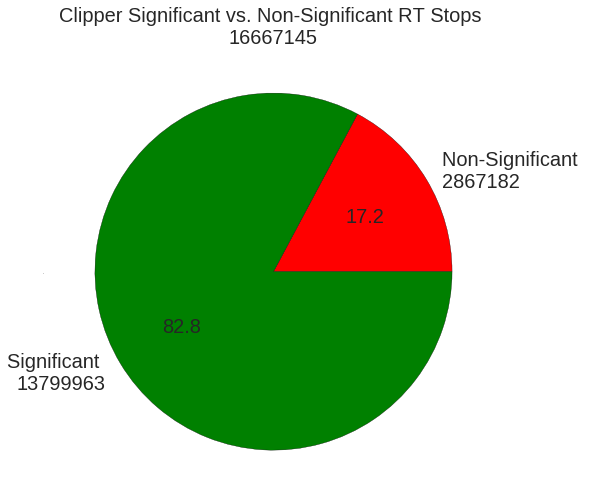

In [46]:
#collect the genic only
clipper_sig_group = RT_through_clipper_merged[RT_through_clipper_merged.genic == "Yes"]
#now plot based on clipper sig
clipper_sig_group = clipper_sig_group.groupby(by='clipper_sig')
clipper_sums = clipper_sig_group.RT_stops_x.sum()
total = clipper_sums.Yes + clipper_sums.No
total = total.astype('str')
clipper_non_sig = clipper_sums.No.astype('str')
clipper_sig = clipper_sums.Yes.astype('str')
clipper_pie = clipper_sums.plot.pie(figsize=(8,8),labels=['Non-Significant \n'+clipper_non_sig,'Significant \n'+ clipper_sig],colors=['r','g'],autopct='%.1f',fontsize=20,title='Clipper Significant vs. Non-Significant RT Stops')
clipper_pie.set_title('Clipper Significant vs. Non-Significant RT Stops \n'+total,fontsize=20)
clipper_pie.set_ylabel('no',fontsize=1)

In [6]:
%%time

#Here we begin the process of preparing clipper reads to be able to plot by biotype

#PROBLEM - now I need to merge the dataframes based on the column ens_gene. The problem is that ens_gene is not unique, so there is a loss of clusters
#SOLUTION - Take most highly expressed gene using the twist_er_cufflinks_dataset
#File to use is the RT_stops_clipper_sig_genes_merged
####PROBLEM - IF THE ENSG ID CANNOT BE FOUND IN THE CUFFLINKS LIST, IT FAILS. FOR THIS I AM JUST TAKING THE FIRST ENTRY FOR THE GENE. Doesn't seem to affect many RT stops though
with open('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes_merged') as f:
    f = f.readlines()
    out_list = []
    counter_list = []
    counter = 0
    ensg_gene_not_found_counter = 0
    for line in f:
        counter += 1
        counter_list.append(counter)
        line = line.strip().split('\t')
        if ',' in line[3]:
            genes = line[3].split(',')
            gene_list = []
            sums_list = []
            for item in genes:
                if item in gene_and_fpkm_sum_dict.keys():
                    gene_list.append((item,gene_and_fpkm_sum_dict[item]))
                    sums_list.append(gene_and_fpkm_sum_dict[item])                    
            if len(sums_list) > 0: #Fix here - if there is no matching gene name for the cluster, just pick the first one in the list. I know this isn't the best, but it is a stopgap measure.
                max_sum = max(sums_list)
                for item in gene_list:
                    if item[1] == max_sum:               
                        line[3]=item[0]
            else:
                line[3]=genes[0]
                ensg_gene_not_found_counter += 1
        out_list.append(line)
with open('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes_merged_highest_expression_filtered','w') as f:
    writer = csv.writer(f,'textdialect')
    writer.writerows(out_list)

CPU times: user 4min 25s, sys: 732 ms, total: 4min 26s
Wall time: 4min 26s


biotype
3prime_overlapping_ncRNA               0.000130
antisense                              0.548523
bidirectional_promoter_lncRNA          0.008203
lincRNA                                8.560001
misc_RNA                               0.013000
processed_pseudogene                   0.009065
processed_transcript                   0.253160
protein_coding                        89.015188
rRNA                                   0.000217
sense_intronic                         0.000239
sense_overlapping                      0.360139
snRNA                                  0.002312
snoRNA                                 0.001935
transcribed_processed_pseudogene       0.026370
transcribed_unitary_pseudogene         0.004942
transcribed_unprocessed_pseudogene     0.208972
unitary_pseudogene                     0.006138
unknown                                0.954459
unprocessed_pseudogene                 0.024044
vaultRNA                               0.002964
Name: RT_stops, dtype: float64


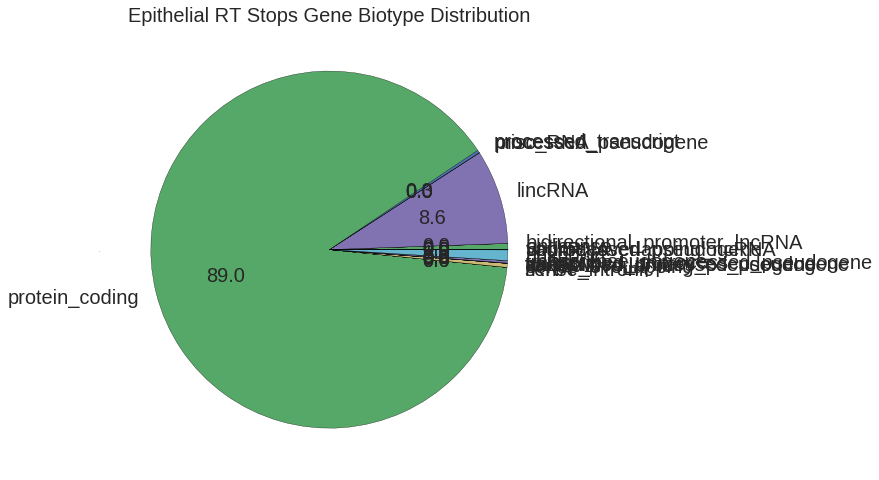

In [12]:
#Now read the expression filtered in as a dataframe
#This is already clipper filtered data
columns = ['chrom','start','end','ens_gene','RT_stops','strand']
rt_stops_highest_expression_filtered_df = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes_merged_highest_expression_filtered',sep='\t',names=columns)

#Merge with the genes_merge_bt from hg19_v19 genes since they have the highest number of genes represented
rt_stops_highest_expression_filtered_genes_and_biotype = pd.merge(rt_stops_highest_expression_filtered_df,genes_merge_df,on='ens_gene',how='left')
rt_stops_highest_expression_filtered_genes_and_biotype.to_csv('hnM_DMSO_clipper/testing',sep='\t',na_rep='NaN')

#Fill na with unknown
rt_stops_highest_expression_filtered_genes_and_biotype.fillna(value='unknown',inplace=True)

#Now groupby biotype to count the amount per various genes
biotype_group = rt_stops_highest_expression_filtered_genes_and_biotype.groupby(by='biotype')

#Make pie chart and print the percentage of RT stops binding to a particular class of genes
rt_stop_total = rt_stops_highest_expression_filtered_genes_and_biotype.RT_stops.sum()
biotype_sums = biotype_group.RT_stops.sum()/rt_stop_total*100
biotype_pie = biotype_sums.plot.pie(figsize=(8,8),autopct='%.1f',fontsize=20)
biotype_pie.set_title('Epithelial RT Stops Gene Biotype Distribution',fontsize=20)
biotype_pie.set_ylabel('no',fontsize=1)
print(biotype_sums)


gene_region
cds                 1.670254
distal_intron      90.633360
proximal_intron     5.002962
utr3                2.152293
utr5                0.541132
Name: RT_stops, dtype: float64
CPU times: user 7.55 s, sys: 528 ms, total: 8.08 s
Wall time: 16.5 s


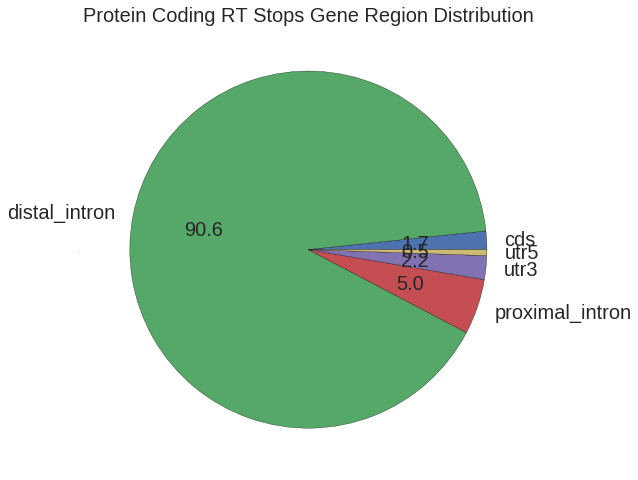

In [8]:
%%time
#annotation bedfiles all from clipper hg19_v19 annotation
#Not sure if this the best annotation - consider trying another
exons = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_exons.bed')
introns = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_introns.bed')
proximal_introns = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_proxintron500.bed')
cds = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_cds.bed')
utr5 = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_five_prime_utrs.bed')
utr3 = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_three_prime_utrs.bed')

#Try the FAST-iCLIP annotation
# exons = pbt.BedTool('/home/sam/bin/FAST-iCLIP/docs/hg19/Exons_Ensbl_sort_clean_uniq.bed')
# utr5 = pbt.BedTool('/home/sam/bin/FAST-iCLIP/docs/hg19/5pUTRs_Ensbl_sort_clean_uniq.bed')
# utr3 = pbt.BedTool('/home/sam/bin/FAST-iCLIP/docs/hg19/3pUTRs_Ensbl_sort_clean_uniq.bed')

#fix the utr5 and utr3 so they do not overlap
#call the utr5 as the non-intersection with utr3 - note this does introduce some bias

utr5 = utr5.intersect(b=utr3,s=True,wa=True,v=True)


#Now collect the protein coding RT stops and intersect with the annotations for exons, introns, CDS, and 5'UTR
protein_coding = rt_stops_highest_expression_filtered_genes_and_biotype[rt_stops_highest_expression_filtered_genes_and_biotype.biotype == 'protein_coding']

header = list(protein_coding.columns.values)

#obtain as a bed file
protein_coding_bt = pbt.BedTool.from_dataframe(protein_coding)

#complete the intersections and reload as dataframes to tabulate

#exons
exon_intersect = protein_coding_bt.intersect(b=exons,s=True,wa=True,u=True)
exon_df = exon_intersect.to_dataframe(names=header)

#obtain intronic reads by intersecting with exons and taking those that don't intersect
intronic_from_exon_intersect = protein_coding_bt.intersect(b=exons,s=True,wa=True,v=True)
intron_df = intronic_from_exon_intersect.to_dataframe(names=header)

#proximal_introns are intronic RT stops that do intersect with proximal introns
proximal_intronic_intersect = intronic_from_exon_intersect.intersect(b=proximal_introns,s=True,wa=True,u=True)
proximal_df = proximal_intronic_intersect.to_dataframe(names=header)
proximal_df['gene_region'] = 'proximal_intron'

#distal introns are intronic RT stops that do not intersect with proximal introns
distal_intronic_intersect = intronic_from_exon_intersect.intersect(b=proximal_introns,s=True,wa=True,v=True)
distal_df = distal_intronic_intersect.to_dataframe(names=header)
distal_df['gene_region'] = 'distal_intron'

#for utrs, intersect with the exonic reads
#utr5
utr5_intersect = exon_intersect.intersect(b=utr5,s=True,wa=True,u=True)
utr5_df = utr5_intersect.to_dataframe(names=header)
utr5_df['gene_region'] = 'utr5'

#utr3
utr3_intersect = exon_intersect.intersect(b=utr3,s=True,wa=True,u=True)
utr3_df = utr3_intersect.to_dataframe(names=header)
utr3_df['gene_region'] = 'utr3'

#cds
#for this, use the utr5 and utr3 output as a mask on the exonic reads
utr_combo = utr5.cat(utr3,postmerge=False)
cds_intersect = exon_intersect.intersect(b=utr_combo,s=True,wa=True,v=True)
cds_df = cds_intersect.to_dataframe(names=header)
cds_df['gene_region'] = 'cds'

#NOTE this doesn't match perfectly. Suggests that some exons are encroaching into introns in the annotation. Shoudl just use the anti of the exons to prevent double counting reads
# intronic_intersect = protein_coding_bt.intersect(b=introns,s=True,wa=True,u=True)
# intronic_intersect.to_dataframe(names=header)

#concat into a new protein coding df
protein_coding_with_gene_region = pd.concat([proximal_df,distal_df,cds_df,utr5_df,utr3_df],ignore_index=True)

#groupby gene region
gene_region_group = protein_coding_with_gene_region.groupby(by='gene_region')

#Make pie chart and print the percentage of RT stops binding to a particular region of protein coding genes
rt_stop_total = protein_coding_with_gene_region.RT_stops.sum()
gene_region_sums = gene_region_group.RT_stops.sum()/rt_stop_total*100
gene_region_pie = gene_region_sums.plot.pie(figsize=(8,8),autopct='%.1f',fontsize=20)
gene_region_pie.set_title('Protein Coding RT Stops Gene Region Distribution',fontsize=20)
gene_region_pie.set_ylabel('no',fontsize=1)
print(gene_region_sums)

In [9]:
sample = '_DMSO'

fig = genic_pie.get_figure()
fig.savefig('pie_charts/genic_pie'+sample,dpi=300)

fig = clipper_pie.get_figure()
fig.savefig('pie_charts/clipper_pie'+sample,dpi=300)

fig = biotype_pie.get_figure()
fig.savefig('pie_charts/biotype_pie'+sample,dpi=300)

fig = gene_region_pie.get_figure()
fig.savefig('pie_charts/gene_region_pie'+sample,dpi=300)
